In [1]:
# --- IMPORTS & RELOAD ---
import importlib, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jeppesen_pipeline as jp

jp = importlib.reload(jp)  # sikrer du bruger nyeste version af modulet
print("Using:", jp.__file__)


Using: c:\Users\kvjkv\.vscode\Epilepsy_MasterThesis\jeppesen_pipeline.py


In [9]:
# --- PATHS & CONFIG ---
TDMS_PATH  = r"D:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 2\recording 1\Patient_2_1.tdms"
INDEX_PATH = r"D:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 2\recording 1\Patient_2_1.tdms_index"

# Hvis TDMS ikke indeholder timing-properties, brug fs_override:
FS_OVERRIDE = 512.0

# Slice (kør kun på et tidsudsnit for hastighed)
START_S = 600.0      # fx start 10 min inde = 600 s
DUR_S   = 300.0      # fx 5 minutter

# Pipeline-parametre
WINDOW_BEATS = 50    # lavere for små udsnit (100 kræver ~100 slag)
AUTO_BASELINE_BEATS = 0  # 0 for små slices
OUT_PREFIX = "slice_test"  # præfiks til plots/CSV-filer


In [12]:
# --- HELPERS ---
def lv_thresholds_for_plot(ecg, fs, params):
    """Returner bp, Thigh, Tlow som i LabVIEW-bygningen, til overlay-plot."""
    bp = jp.bandpass_filter(ecg, fs, 0.5, 32.0, 4)
    L = int(round(params.win_s*fs))
    rect = np.maximum(bp, 0.0)

    # vindue-max
    wmax, edges = [], []
    for st in range(0, len(rect), L):
        en = min(len(rect), st+L)
        wmax.append(np.max(rect[st:en]) if en>st else 0.0)
        edges.append((st,en))
    wmax = np.array(wmax)

    # Thigh pr. vindue (median af seneste 8) * 0.75
    thigh_w = np.zeros_like(wmax)
    for k in range(len(wmax)):
        if k == 0: thigh_w[k] = 0.75*wmax[0]
        else:
            lo = max(0, k-8)
            med = np.median(wmax[lo:k]) if k>0 else wmax[k]
            thigh_w[k] = 0.75*med

    # Kopiér pr. vindue-værdi ud over samples
    thigh = np.zeros(len(bp))
    for k,(st,en) in enumerate(edges):
        thigh[st:en] = thigh_w[k]
    tlow = 0.4*thigh
    return bp, thigh, tlow

def plot_ecg_with_peaks(ecg, fs, peaks, title="ECG + peaks", t0=0.0):
    t = t0 + np.arange(len(ecg))/fs
    plt.figure(figsize=(10,3))
    plt.plot(t, ecg, lw=0.8)
    if len(peaks):
        plt.plot(t0 + peaks/fs, ecg[peaks], "o", ms=4)
    plt.xlabel("Time (s)"); plt.title(title)
    plt.tight_layout(); plt.show()

def plot_overlay(bp, thigh, tlow, fs, peaks=None, start_s=0.0, dur_s=10.0, t0=0.0, title="Thigh/Tlow overlay"):
    j0, j1 = int(start_s*fs), int((start_s+dur_s)*fs)
    tt = t0 + np.arange(len(bp))/fs
    plt.figure(figsize=(10,4))
    plt.plot(tt[j0:j1], bp[j0:j1], label="Filtered ECG")
    plt.plot(tt[j0:j1], thigh[j0:j1], '--', label="Thigh")
    plt.plot(tt[j0:j1], tlow[j0:j1],  '--', label="Tlow")
    if peaks is not None and len(peaks):
        pwin = peaks[(peaks>=j0) & (peaks<j1)]
        plt.plot(tt[pwin], bp[pwin], 'o', label="Peaks")
    plt.legend(); plt.xlabel("Time (s)"); plt.title(title)
    plt.tight_layout(); plt.show()


# Notebook helper: detekter R-peaks med fs-skalering + auto-polaritet,
# selv om jp.LVParams ikke har 'auto_polarity'.
def detect_labview_with_autopol(ecg, fs, auto_polarity="global16s"):
    import numpy as np
    import jeppesen_pipeline as jp

    x = ecg.astype(float).copy()

    # auto-polaritet
    if auto_polarity == "global16s":
        n = int(16*fs)
        seg = x[:min(len(x), n)]
        if seg.size:
            pos95 = np.percentile(seg, 95)
            neg05 = np.percentile(seg, 5)
            if abs(neg05) > pos95:
                x *= -1.0
    elif auto_polarity == "per_window":
        L = int(round(2.0*fs))  # 2 s vinduer som i VI
        for st in range(0, len(x), L):
            en = min(len(x), st+L)
            seg = x[st:en]
            if seg.size and abs(np.min(seg)) > np.max(seg):
                x[st:en] = -seg

    # fs-skalering af sample-baserede konstanter (15 og 35 @256 Hz)
    scale = fs/256.0
    params = jp.LVParams(
        fs=fs,
        fwd_bwd_radius_samp=int(round(15*scale)),
        delta_thresh_samples=int(round(35*scale))
        # resten af LVParams er i sekunder og skal ikke skaleres
    )
    return jp.LabVIEWRpeak(params).detect(x), x  # returnér også evt. polaritets-korrigeret signal


In [10]:
# --- LOAD TDMS & SLICE ---
x, t_sec, fs, *_ = jp.read_tdms_auto(TDMS_PATH, fs_override=FS_OVERRIDE)

i0, i1 = int(START_S*fs), int((START_S+DUR_S)*fs)
x_win = x[i0:i1]
print(f"Slice: {START_S:.1f}s → {START_S+DUR_S:.1f}s  |  samples: {len(x_win)}  |  fs={fs}")

# --- RUN PIPELINE (LabVIEW-mode) ---
res = jp.run_pipeline_from_ecg(
    ecg=x_win, fs=fs,
    rpeak_mode="labview",          # bruger LVParams(fs=fs, auto_polarity="global16s")
    window_beats=WINDOW_BEATS,
    auto_baseline_beats=AUTO_BASELINE_BEATS,
    plots=True, out=OUT_PREFIX
)
print("Keys:", res.keys())
print("Detected peaks:", len(res["peaks"]))


Slice: 600.0s → 900.0s  |  samples: 153600  |  fs=512.0
Keys: dict_keys(['peaks', 'rr_sec', 't_rr', 'features', 'detections', 'meta'])
Detected peaks: 116


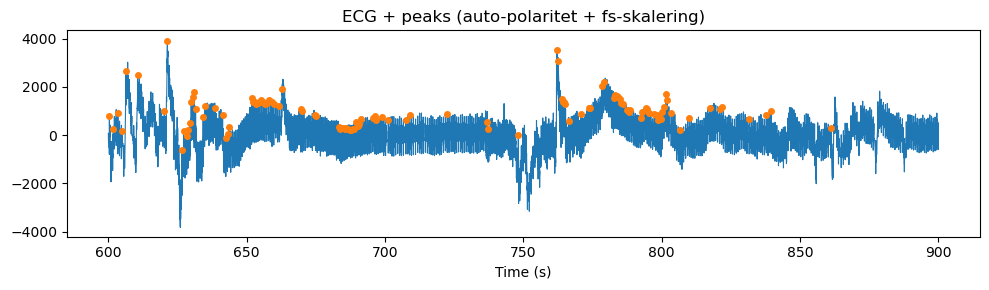

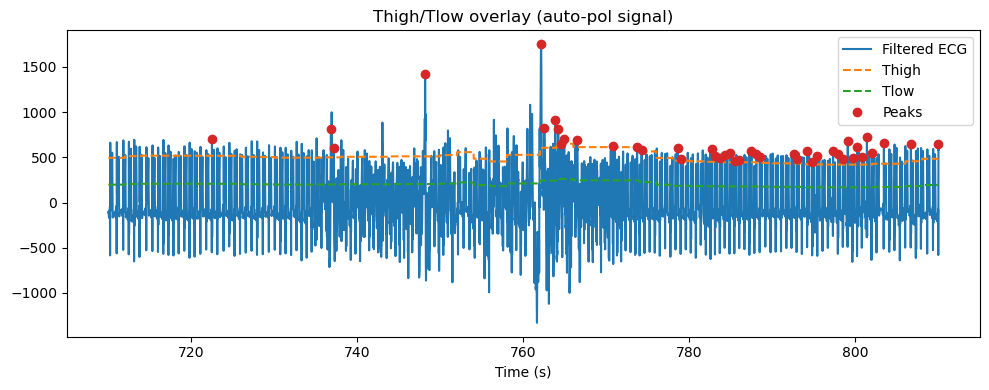

In [15]:
peaks, x_win_pol = detect_labview_with_autopol(x_win, fs, auto_polarity="global16s")

# Plot rå + peaks
plot_ecg_with_peaks(x_win_pol, fs, peaks, title="ECG + peaks (auto-polaritet + fs-skalering)", t0=START_S)

# Overlay Thigh/Tlow (brug params uden auto_polarity)
params = jp.LVParams(fs=fs)
bp, thigh, tlow = lv_thresholds_for_plot(x_win_pol, fs, params)
plot_overlay(bp, thigh, tlow, fs, peaks=peaks,
             start_s=110.0, dur_s=100.0, t0=START_S,
             title="Thigh/Tlow overlay (auto-pol signal)")


In [ ]:
# --- EXPORTS ---
fs_used = fs  # peaks er i "fs" (vi resampler ikke i denne notebook)

peaks = res["peaks"].astype(int)
df_peaks = pd.DataFrame({
    "peak_sample": peaks,
    "peak_time_s": START_S + peaks / float(fs_used)  # absolut tid ift. recording start
})
df_rr = pd.DataFrame({"t_rr_s": START_S + res["t_rr"], "rr_s": res["rr_sec"]})

df_peaks.to_csv(f"{OUT_PREFIX}_peaks.csv", index=False)
df_rr.to_csv(f"{OUT_PREFIX}_rr.csv", index=False)
res["features"].to_csv(f"{OUT_PREFIX}_features.csv", index=False)
res["detections"].to_csv(f"{OUT_PREFIX}_detections.csv", index=False)

print("Saved CSVs:",
      f"{OUT_PREFIX}_peaks.csv",
      f"{OUT_PREFIX}_rr.csv",
      f"{OUT_PREFIX}_features.csv",
      f"{OUT_PREFIX}_detections.csv")
